## HUD Volume Estimation

In [1]:
import numpy as np
import pandas as pd

In [2]:
def ScaledDiffuserScreenWidth(inputs):
    ScalingFactor = inputs["FullHorizontalFOV"]/10
    return inputs["HUD_SCREEN_10x5_FOV_BASELINE_WIDTH"] * ScalingFactor


## Calculations
### Mirror Size Calculations

##### Mirror 1
def RaySlopeH_m(inputs):
    return (np.tan(np.radians(inputs["FullHorizontalFOV"]/2))*inputs["VirtualImageDistance"]-inputs["EyeboxFullWidth"]/2)/(-inputs["VirtualImageDistance"])
    
def InterceptH(inputs):
    return inputs["EyeboxFullWidth"]/2

def Mirror1Horizontal(inputs):
    points = {
        "Mirror1TopPointXH" : -inputs["EyeboxToMirror1"],
        "Mirror1TopPointYH" : RaySlopeH_m(inputs) * (-inputs["EyeboxToMirror1"]) + InterceptH(inputs),
        "Mirror1BottomPointXH" : -inputs["EyeboxToMirror1"],
        "Mirror1BottomPointYH" : -RaySlopeH_m(inputs) * (-inputs["EyeboxToMirror1"]) + InterceptH(inputs)
    }
    return points

def RaySlopeV_m(inputs):
    return (np.tan(np.radians(inputs["FullVerticalFOV"]/2))*inputs["VirtualImageDistance"]-inputs["EyeboxFullHeight"]/2)/(-inputs["VirtualImageDistance"])

def InterceptV(inputs):
    return inputs["EyeboxFullHeight"]/2

def MirrorFullHeight(inputs):
    #TiltAngleOfM1 = Mirror1ObliquityAngle #degrees
    TopPointX    = ( -InterceptV(inputs) * np.tan(np.radians(inputs["Mirror1ObliquityAngle"])) - inputs["EyeboxToMirror1"]) / (1+np.tan(np.radians(inputs["Mirror1ObliquityAngle"])) * RaySlopeV_m(inputs))
    BottomPointX = (  InterceptV(inputs) * np.tan(np.radians(inputs["Mirror1ObliquityAngle"])) - inputs["EyeboxToMirror1"]) / (1-np.tan(np.radians(inputs["Mirror1ObliquityAngle"])) * RaySlopeV_m(inputs))

    TopPointY    = (  RaySlopeV_m(inputs) * TopPointX    ) + InterceptV(inputs)
    BottomPointY = ( -RaySlopeV_m(inputs) * BottomPointX ) - InterceptV(inputs)

    return np.sqrt(np.power(TopPointX-BottomPointX,2)+np.power(TopPointY-BottomPointY,2))

#### M1 focal length calculation
def M1ToVirtualImage(inputs):
    return inputs["VirtualImageDistance"]-inputs["EyeboxToMirror1"] #(s2) mm

def SceenToM1(inputs):
    ## Screen and Image Calculations		
    VirtualImageWidth = np.tan(np.radians(inputs["FullHorizontalFOV"]/2))*inputs["VirtualImageDistance"]*2 #mm
    HUDImageMagnification = VirtualImageWidth/ScaledDiffuserScreenWidth(inputs)	#x
    return M1ToVirtualImage(inputs)/HUDImageMagnification #mm


### HUD Volume Calculation
def VolumeBetweenScreenAndM1Liters(inputs):
    ## Primary mirror size estimate
    Mirror1HorizontalDiameterEstimate = Mirror1Horizontal(inputs)["Mirror1TopPointYH"]*2 #mm
    Mirror1VerticalDiameterEstimate = MirrorFullHeight(inputs) #mm

    Mirror1Width = Mirror1HorizontalDiameterEstimate #mm
    Mirror1Height = Mirror1VerticalDiameterEstimate #mm
    Mirror1Area = Mirror1Width*Mirror1Height #mm^2
            
    ScreenToM1 = SceenToM1(inputs) #mm
    ScreenWidth = ScaledDiffuserScreenWidth(inputs) #mm
    ScreenHeight = (inputs["FullVerticalFOV"]/inputs["FullHorizontalFOV"])*ScaledDiffuserScreenWidth(inputs) #mm
            
    # Find height of pyramid from base		
    HalfDiagonalM1 = 0.5*(np.sqrt(np.power(Mirror1Width,2)+np.power(Mirror1Height,2))) #Y2
    HalfDiagonalScreen = 0.5*(np.sqrt(np.power(ScreenWidth,2)+np.power(ScreenHeight,2))) #Y1
    Slope = (HalfDiagonalScreen-HalfDiagonalM1)/ScreenToM1 #(m)
    #x=0, y=0, so b=0		
    X2 = HalfDiagonalM1/Slope
    X1 = HalfDiagonalScreen/Slope
    ApexFromMirror1 = np.absolute(X2)
    ApexFromScreen = np.absolute(X1)

    # Find Mirror to screen volume
    AreaPyramidFromMirror = (1/3)*Mirror1Width*Mirror1Height*ApexFromMirror1 #mm^3
    AreaPyramidFromScreen = (1/3)*ScreenWidth*ScreenHeight*ApexFromScreen #mm^3
    VolumeBetweenScreenAndM1 = AreaPyramidFromMirror-AreaPyramidFromScreen #mm^3

    return 0.000001*VolumeBetweenScreenAndM1

## Outputs
### HUD Volume Estimate
def TotalMechanicalVolumeOfHUD(inputs):
    ## Primary mirror size estimate
    Mirror1HorizontalDiameterEstimate = Mirror1Horizontal(inputs)["Mirror1TopPointYH"]*2 #mm
    Mirror1VerticalDiameterEstimate = MirrorFullHeight(inputs) #mm

    VolumeFromHUDmirrors = VolumeBetweenScreenAndM1Liters(inputs)*(1-inputs["M1M2OverlapFraction"]/100) #Liters
    #print("Volume from HUD mirrors: {:.2f} liters".format(VolumeFromHUDmirrors))
    VolumeFromMirrorsAndPGU = VolumeFromHUDmirrors+inputs["PGUVolumeEstimate"] #Liters
    #print("Volume from mirrors + PGU: {:.2f} liters".format(VolumeFromMirrorsAndPGU))
    total = VolumeFromMirrorsAndPGU*(1+inputs["MechanicalVolumeIncrease"]/100)
    #print("Total Mechanical Volume of HUD: {:.2f} liters".format(total))
    return total


In [3]:
inputs = {
    "FullHorizontalFOV" : 10,
    "FullVerticalFOV" : 4,
    "VirtualImageDistance" : 15000,
    "EyeboxToMirror1" : 1000,
    "EyeboxFullWidth" : 140,
    "EyeboxFullHeight" : 60,
    "Mirror1ObliquityAngle" : 30,
    "HUD_SCREEN_10x5_FOV_BASELINE_WIDTH" : 70,
    "MechanicalVolumeIncrease" : 40,
    "M1M2OverlapFraction" : 0,
    "PGUVolumeEstimate" : 0.5
}

TotalMechanicalVolumeOfHUD(inputs)

10.562354834597118

## Surplus Value

In [4]:
import math
import simpy
import simpy.util
import settings as s

In [5]:
# Input variables

# FullHorizontalFOV = 10
# FullVerticalFOV = 4
# mirrorSize = 200
# volume = 4
# expectedPerformance = 10
# unitCost = 0.001
# cost_redesign = 0.005

# Calculate engineering variables

## calculate % FoV

def calculate_fov(FullHorizontalFOV,FullVerticalFOV):
    """calculate a metric for the FOV of the HUD"""
    FoV = (FullHorizontalFOV * FullVerticalFOV * 100) / (67 * 20)
    return FoV

## cost model

def calculate_cost_vehicle(cost_mirror_unit, mirrorSize, cost_vehicle_without_HUD, cost_assembly, cost_redesign):
    """calculate the cost of the vehicle"""
    cost_mirror = cost_mirror_unit * mirrorSize
    cost_vehicle = cost_mirror + cost_vehicle_without_HUD + cost_assembly + cost_redesign # euro
    return cost_vehicle

## weight model

def calculate_weight_vehicle(volume, weight_vehicle_without_HUD):
    """calculate the weight of the vehicle"""       
    weight_hud = 0.1 * volume  # kg
    weight_vehicle = weight_hud + weight_vehicle_without_HUD # kg
    return weight_vehicle

## fuel consumption model

def calculate_fuel_consumption(volume, weight_vehicle_without_HUD):
    """calculate the fuel consumption of the vehicle"""
    fuel_consumpt = calculate_weight_vehicle(volume, weight_vehicle_without_HUD) * math.exp(-4.7)  # km / liter
    return fuel_consumpt

def calculate_fuel_cost(volume, weight_vehicle_without_HUD, kilometers_year, cost_fuel):
    """calculate the fuel cost of the vehicle"""
    fuel_consumpt = calculate_fuel_consumption(volume, weight_vehicle_without_HUD)
    fuel_cost_year = (kilometers_year/fuel_consumpt) * cost_fuel # keuro / year
    return fuel_cost_year

## calculate demand, copied from demand.py

def calculate_demand(FullHorizontalFOV, FullVerticalFOV, volume, weight_vehicle_without_HUD, cost_fuel, person_height, price_vehicle, year):
    """calculate the demand of the vehicle"""
    Lin_no__1 = (400.389457364428
                + -0.0496637629531165    * (calculate_fov(FullHorizontalFOV, FullVerticalFOV))
                +  0.0438458326033747    * (calculate_fuel_consumption(volume, weight_vehicle_without_HUD))
                +  3.53646955685314      * (cost_fuel * 1000)
                + -0.0958055046356103    * (person_height)
                +  0.0000987106990985412 * (price_vehicle * 1000)
                + -0.193495221339535     * (year)
                )
    Prob_yes_1 = 1 / (1 + math.exp(Lin_no__1)) # demand
    return Prob_yes_1


# create class for Surplus Value Model

class SV:

    # configuration

    price_vehicle = 35000 / 1000 # k€uro/vehicle
    cost_assembly = 556.20 / 1000 # k€euro/vehicle
    cost_vehicle_without_HUD = 20000 / 1000  # k€uro /vehicle
    weight_vehicle_without_HUD = 1800 # kg /vehicle
    cost_fuel = 1.9 / 1000 # kEuro / liter
    kilometers_year = 10000 # km/year
    market_window = 2 # years # TODO this could be an input parameter
    sales_distr = [0.2, 0.4, 0.8, 1, 1, 1, 1, 1, 0.8, 0.4, 0.2]
    theoretical_demand = 70000 # vehicles/year
    operation_time = 10 # years
    development_time = 0 # years
    production_time = 0.1 # years
    sales_time = 0.1 # years
    #year = 2035 #year
    person_height = 180 # cm

    # Redesign costs
    #cost_redesign = 1000 # k€ / liter

    # configuration of simulation

    discrete_time = 0.01
    discount_rate = 0.08
    simulation_duration = 30 # years
    time_between_counting = 1 # year

    def __init__(self, env, FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, year):

        self.env = env

        self.FullHorizontalFOV = FullHorizontalFOV
        self.FullVerticalFOV = FullVerticalFOV
        self.mirrorSize = mirrorSize
        self.volume = volume
        self.expectedPerformance = expectedPerformance #HFoV*VFoV
        self.cost_mirror_unit = unitCost # k€/mm
        self.cost_redesign = cost_redesign # k€/l
        self.year = year

        self.i = 0

        # initializing costs and revenues

        self.development_cost = 0
        self.production_cost = 0
        self.integration_cost = 0
        self.operation_cost = 0

        self.total_development_cost = 0
        self.total_production_cost = 0
        self.total_operation_cost = 0
        self.total_revenue = 0
        self.total_cost = 0

        self.cost = 0
        self.revenue = 0
        self.net_revenue = - self.cost
        self.NPV = self.net_revenue / (1 + self.discount_rate) ** env.now
        self.cumulativeNPV = self.NPV

        # initializing data for plot
        self.obs_time = [env.now]
        self.cashflow_level = [self.cumulativeNPV]

        # initializing counters for the different phases

        self.total_demand = 0
        self.in_development = 0
        self.in_production = 0
        self.in_sale = 0
        self.total_produced = 0
        self.in_operation = 0
        self.EoL = 0

        # start the business process every time an option is defined, start the development,
        # if development time != 0, start the market delayed, else start instantaneously

        # self.action = start_delayed(env, self.market(market_window, time_between_counting), self.development_time)

        self.action = env.process(self.lifecycle())

        self.action = env.process(self.observe())

        self.action = env.process(self.calculate())

    def lifecycle(self):

        self.in_development = 1

        yield self.env.timeout(self.development_time)

        self.in_development = 0

        self.action = self.env.process(self.market())

    def market(self):

        while self.env.now < self.market_window:

            self.action = self.env.process(self.business_run())

            yield self.env.timeout(self.time_between_counting)

            self.i += 1

    def business_run(self):

        # set vehicle demand

        self.current = math.ceil(s.theoretical_demand 
                                * calculate_demand(self.FullHorizontalFOV, 
                                                  self.FullVerticalFOV, 
                                                  self.volume, 
                                                  self.weight_vehicle_without_HUD, 
                                                  self.cost_fuel, 
                                                  self.person_height, 
                                                  self.price_vehicle, 
                                                  self.year)
                                * s.sales_distr[self.i])   # calculation of current demand

        # set vehicles in production

        self.in_production += self.current

        yield self.env.timeout(s.production_time)

        # after production_time, vehicles are in sale

        self.in_production -= self.current

        self.in_sale += self.current

        yield self.env.timeout(s.sales_time)

        # after sales time, set vehicles in use

        self.in_sale -= self.current

        self.in_operation += self.current

        yield self.env.timeout(s.operation_time)

        # after operation time, set vehicles out of life

        self.in_operation -= self.current

        self.EoL += self.current

    def observe(self):
        while True:

            self.obs_time.append(self.env.now)
            self.cashflow_level.append(self.cumulativeNPV)

            #print (self.revenue)

            #if self.cumulativeNPV < 0:
                #self.payback_period = env.now

            yield self.env.timeout(s.discrete_time)

    def calculate(self):
        """function for cost, revenue and NPV calculations"""

        while True:
            # all calculations are scaled down by the discrete time

            self.production_cost = (self.in_production
                                   * (calculate_cost_vehicle(self.cost_mirror_unit, 
                                                           self.mirrorSize, 
                                                           self.cost_vehicle_without_HUD, 
                                                           self.cost_assembly,
                                                           self.cost_redesign))
                                   * s.discrete_time)  # the total cost is "spread" along the production time

            self.revenue = self.in_sale * (s.price_vehicle) * s.discrete_time

            #self.operation_cost = self.in_operation * ((kilometers_year/fuel_consumpt) * cost_fuel) * discrete_time

            self.total_revenue += self.revenue

            # sum of cost and revenue and caluclation of NPV
            self.cost = self.production_cost #+ self.operation_cost
            self.total_cost -= self.cost
            self.net_revenue = self.revenue - self.cost
            self.NPV = self.net_revenue / (1 + s.discount_rate) ** self.env.now
            self.cumulativeNPV += self.NPV

            yield self.env.timeout(s.discrete_time)



# run Surplus Value of alternative
# launch environment

def surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, year):

    env = simpy.Environment()
    #simpy.util.start_delayed(env, simulation_run(env), delay=1)
    hud = SV(env, FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, year)
    #print("Starting simulation.")
    env.run(until=s.simulation_duration)
    #print("End of simulation.")

    surplus_value = hud.cumulativeNPV/1000 # converted in million euro
    lifecycle_costs = -hud.total_cost/1000

    #print(surplus_value)
    return surplus_value, lifecycle_costs



In [6]:
FullHorizontalFOV = 1
FullVerticalFOV = 1
mirrorSize = 1
volume = 1
expectedPerformance = 1
unitCost = 1
cost_redesign = 1

print(surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, 2022))
print(surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, 2023))
print(surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, 2024))
print(surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, 2025))
print(surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, 2026))
print(surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, 2027))
print(surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, 2028))
print(surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, 2029))
print(surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign, 2030))

(2.535349733311271, 5.50822404)
(3.038804472231867, 6.602199739999999)
(3.6337084022840203, 7.894670000000001)
(4.331396780983926, 9.410446640000002)
(5.147443009641856, 11.183363960000001)
(6.091191129043964, 13.233722539999999)
(7.178214540500513, 15.595356679999998)
(8.414742604535618, 18.2818001)
(9.807004681673385, 21.306586520000003)


## Value Weighted Filtered Outdegree

From:
Viscito, L. and Ross, A.M. (2009), “Quantifying Flexibility in Tradespace Exploration: Value Weighted Filtered Outdegree”, AIAA Space 2009 Conference and Exposition, pp. 14–17.

In [7]:
from doepy import build
import matplotlib.pyplot as plt

In [8]:
# N is the number of designs considered
N = 100
# k is the current epoch (k+1) is the next epoch in the era
k = 1
# i is the design under consideration
i = 1
# j is the destination design
j = 2
# u_i^{k+1} is the utility of the design under consideration (i) in the k+1 epoch
# u_j^{k+1} is the utility of the design j in the k+1 epoch
# Arc_{i,j}^{k} is the transition matrix with local value indicating an arc from design i to design j in the k epoch

sign = lambda x: -1 if x < 0 else (1 if x > 0 else 0)

def u(i,k):
    utility = i*k
    return utility

def Arc(i,j,k):
    arc = 1
    return arc

def VWFO(i,k):
    epsilon = 0
    for j in range(1,N-1,1):
        epsilon = epsilon + sign(u(j,k+1)-u(i,k+1)) * Arc(i,j,k)
    vwfo = 1 / (N-1)
    return vwfo

print(VWFO(i,k))

0.010101010101010102


In [9]:
class Design:
    def __init__(self, scenario, platform, technology, t_x1, t_x2, t_x3):
        self.scenario = scenario
        self.technology = technology
        self.platform = platform
        self.platform_compatible = None
        self.t_x1 = t_x1
        self.t_x2 = t_x2
        self.t_x3 = t_x3
        if technology == 1:
            # self.volume = t_x1 * t_x2 * np.sqrt(t_x3) / 500
            self.volume = TotalMechanicalVolumeOfHUD({
                    "FullHorizontalFOV" : self.t_x1,
                    "FullVerticalFOV" : self.t_x2,
                    "VirtualImageDistance" : self.t_x3,
                    "EyeboxToMirror1" : 1000,
                    "EyeboxFullWidth" : 140,
                    "EyeboxFullHeight" : 60,
                    "Mirror1ObliquityAngle" : 30,
                    "HUD_SCREEN_10x5_FOV_BASELINE_WIDTH" : 70,
                    "MechanicalVolumeIncrease" : 40,
                    "M1M2OverlapFraction" : 0,
                    "PGUVolumeEstimate" : 0.5}
            )
            self.x = np.cbrt(self.volume / (1 + 3 + 1)) * 100 # in mm
            self.y = 3 * self.x
            self.z = 1 * self.x
            self.value, self.cost = surplus_value(FullHorizontalFOV=self.t_x1, FullVerticalFOV=self.t_x2, mirrorSize=100, volume=self.volume, expectedPerformance=100, unitCost=self.scenario.s_x3, cost_redesign=-10*(self.volume), year=self.scenario.s_x2[0])
        elif technology == 2:
            # self.volume = t_x1 * t_x2 * np.sqrt(t_x3) / 500
            self.volume = TotalMechanicalVolumeOfHUD({
                    "FullHorizontalFOV" : self.t_x1,
                    "FullVerticalFOV" : self.t_x2,
                    "VirtualImageDistance" : self.t_x3,
                    "EyeboxToMirror1" : 1000,
                    "EyeboxFullWidth" : 140,
                    "EyeboxFullHeight" : 60,
                    "Mirror1ObliquityAngle" : 30,
                    "HUD_SCREEN_10x5_FOV_BASELINE_WIDTH" : 70,
                    "MechanicalVolumeIncrease" : 40,
                    "M1M2OverlapFraction" : 0,
                    "PGUVolumeEstimate" : 0.5}
            )
            self.x = np.cbrt(self.volume / (1 + 3 + 2)) * 100 # in mm
            self.y = 3 * self.x
            self.z = 2 * self.x
            self.value, self.cost = surplus_value(FullHorizontalFOV=self.t_x1, FullVerticalFOV=self.t_x2, mirrorSize=100, volume=self.volume, expectedPerformance=100, unitCost=self.scenario.s_x3, cost_redesign=-40*(self.volume-10)**2, year=self.scenario.s_x2[0])
        elif technology == 3:
            self.volume = np.sqrt(t_x1 * t_x2 * np.sqrt(t_x3)) / 20
            self.x = np.cbrt(self.volume / (1 + 3 + 0.5)) * 100 # in mm
            self.y = 3 * self.x
            self.z = 0.5 * self.x
            self.value, self.cost = surplus_value(FullHorizontalFOV=self.t_x1, FullVerticalFOV=self.t_x2, mirrorSize=100, volume=self.volume, expectedPerformance=100, unitCost=self.scenario.s_x3, cost_redesign=-10*(self.volume)**2.7, year=self.scenario.s_x2[0])
        self.value = self.value * self.scenario.id / 100

class Platform:
    def __init__(self, id, p_x1, p_x2, p_x3):
        self.id = id
        self.p_x1 = p_x1
        self.p_x2 = p_x2
        self.p_x3 = p_x3
        self.volume_available = p_x1 * p_x2 * p_x3

class Technology:
    def __init__(self, id, name, volume_coeficients, factors):
        self.id = id
        self.name = name
        self.volume_coeficients = volume_coeficients
        self.factors = factors

class Scenario:
    def __init__(self, id, description, s_x1, s_x2, s_x3):
        self.id = id
        self.description = description
        self.s_x1 = s_x1
        self.s_x2 = s_x2
        self.s_x3 = s_x3


In [10]:
def calculate_tradespace_designs(factors, num_samples, scenario, platform, technology):

    lhs = build.space_filling_lhs(factors, num_samples=num_samples)

    designs = []
    for index, row in lhs.iterrows():
        design_t = Design(scenario, platform, technology,row['t_x1'],row['t_x2'],row['t_x3'])
        if (design_t.x <= platform.p_x1) and (design_t.y <= platform.p_x2) and (design_t.z <= platform.p_x3):
            design_t.platform_compatible = True
        else:
            design_t.platform_compatible = False
        designs.append(design_t)
        # print(f"Design {index} \n x = {design_t.x}\t{platform.p_x1} \n y = {design_t.y}\t{platform.p_x2} \n z = {design_t.z}\t{platform.p_x3} \n Compatibility = {design_t.platform_compatible}")

    return designs

In [11]:
num_samples = 100

scenarios = [
    Scenario(id=1, description="Scenario 1", s_x1=["Technology 1", "Technology 2"],                 s_x2=[2022, 2024], s_x3=100),
    Scenario(id=2, description="Scenario 2", s_x1=["Technology 1", "Technology 2"],                 s_x2=[2024, 2026], s_x3=80),
    Scenario(id=3, description="Scenario 3", s_x1=["Technology 1", "Technology 2", "Technology 3"], s_x2=[2026, 2030], s_x3=80)
]

platforms = [
    Platform(id=1, p_x1=300, p_x2=250, p_x3=200),
    Platform(id=2, p_x1=400, p_x2=400, p_x3=300),
    Platform(id=3, p_x1=350, p_x2=350, p_x3=250)
]

technologies = [Technology(id=1, name='Technology 1', volume_coeficients=[1, 3, 1],  factors={'t_x1':[5,10],  't_x2':[2,4],  't_x3':[1000,5000]}),
                Technology(id=2, name='Technology 2', volume_coeficients=[1, 3, 2],  factors={'t_x1':[7,15],  't_x2':[3,7],  't_x3':[5000,20000]}),
                Technology(id=3, name='Technology 3', volume_coeficients=[1, 3, .5], factors={'t_x1':[10,20], 't_x2':[4,10], 't_x3':[1000,30000]})
                ]



In [12]:
# Test to draw the edges of the parameters envelope

designs = []

points = [
    [0,0,0],
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1]
]

for i, scenario in enumerate(scenarios):
    for j, platform in enumerate(platforms):
        for k, technology in enumerate(technologies):
            for point in points:
                design_t = Design(scenario, platform, technology.id,technology.factors['t_x1'][point[0]],technology.factors['t_x2'][point[1]],technology.factors['t_x3'][point[2]])
                if (design_t.x <= platform.p_x1) and (design_t.y <= platform.p_x2) and (design_t.z <= platform.p_x3):
                    design_t.platform_compatible = True
                else:
                    design_t.platform_compatible = False
                designs.append(design_t)

C:\Users\inigo\AppData\Local\Temp\ipykernel_31496\3934931015.py:69: RuntimeWarning: divide by zero encountered in double_scalars
  Slope = (HalfDiagonalScreen-HalfDiagonalM1)/ScreenToM1 #(m)


In [13]:
designs[0].x

51.92494101851104

In [14]:
designs = []
for i, scenario in enumerate(scenarios):
    designs.append([])
    designs_scenario = []
    for j, platform in enumerate(platforms):
        designs_scenario.append([])
        designs_platform = []
        for k, technology in enumerate(technologies):
            if technology.name in scenario.s_x1:
                print(f"Scenario {i+1} Platform {j+1} Technology {k+1}")
                #designs_scenario.append([i,j,k])
                designs_platform += calculate_tradespace_designs(technology.factors, num_samples, scenario, platform, technology.id)
        designs_scenario[j] = designs_platform

    designs[i] = designs_scenario

#designs

Scenario 1 Platform 1 Technology 1


C:\Users\inigo\AppData\Local\Temp\ipykernel_31496\3934931015.py:69: RuntimeWarning: divide by zero encountered in double_scalars
  Slope = (HalfDiagonalScreen-HalfDiagonalM1)/ScreenToM1 #(m)


Scenario 1 Platform 1 Technology 2
Scenario 1 Platform 2 Technology 1
Scenario 1 Platform 2 Technology 2
Scenario 1 Platform 3 Technology 1
Scenario 1 Platform 3 Technology 2
Scenario 2 Platform 1 Technology 1
Scenario 2 Platform 1 Technology 2
Scenario 2 Platform 2 Technology 1
Scenario 2 Platform 2 Technology 2
Scenario 2 Platform 3 Technology 1
Scenario 2 Platform 3 Technology 2
Scenario 3 Platform 1 Technology 1
Scenario 3 Platform 1 Technology 2
Scenario 3 Platform 1 Technology 3
Scenario 3 Platform 2 Technology 1
Scenario 3 Platform 2 Technology 2
Scenario 3 Platform 2 Technology 3
Scenario 3 Platform 3 Technology 1
Scenario 3 Platform 3 Technology 2
Scenario 3 Platform 3 Technology 3


- [ ] Add platform_volume as an input to the design, so the SV simulation can compare it to the volume of the design to determine the cost of redesign (if bigger than the platform volume cost goes up)
- [ ] Do the size check outside the SV simulation, while looping


For each of the technologies, derive a set of possible designs  by varying the design parameters

For each of the designs, check if it is compatible with each of the platforms

For each of the scenarios, define the Valöue of the designs that are compatible with any of the platforms

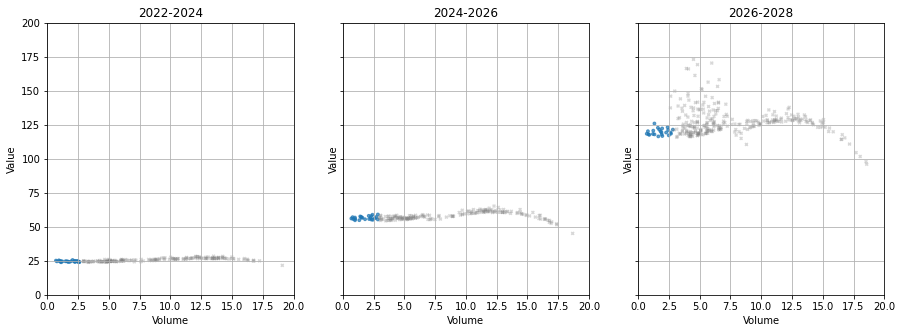

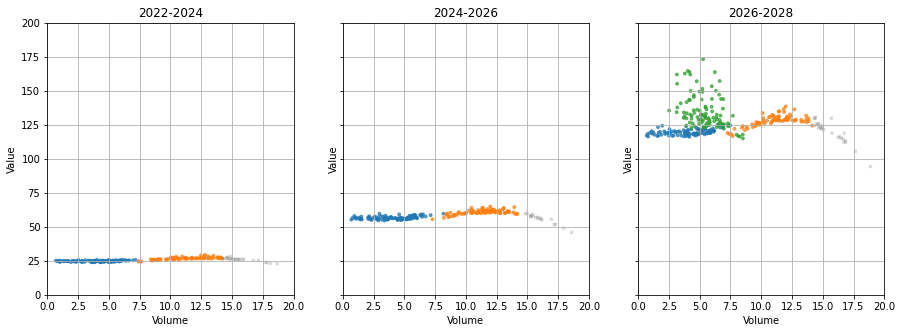

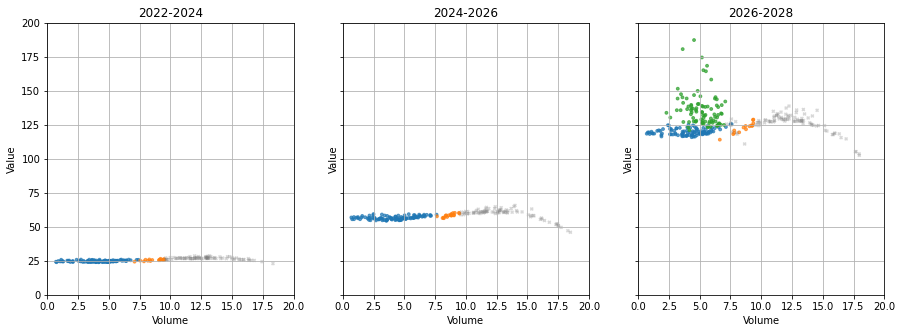

In [15]:
marker_options = ['s', 'o', 'x', 'v', '^', '<', '>', '8', 'p', '*', 'h', 'H', 'D', 'd']

color_options = ['#1f77b4', '#ff7f0e', '#2ca02c', '#8fbbd9', '#ffbf86', '#95cf95', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']



for platform in [0,1,2]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    #fig.suptitle(f"Tradespace storyboard of an sequence of 3 scenarios", fontsize=16)
    for scenario in [0,1,2]:
        x_in =  [design.volume for design in designs[scenario][platform] if design.platform_compatible]
        x_out = [design.volume for design in designs[scenario][platform] if not design.platform_compatible]
        y_in =  [-design.value for design in designs[scenario][platform] if design.platform_compatible]
        y_out = [-design.value for design in designs[scenario][platform] if not design.platform_compatible]
        markers = ['o' if design.platform_compatible else 'x' for design in designs[scenario][platform]]
        colors = [color_options[design.technology-1] if design.platform_compatible else color_options[design.technology+2] for design in designs[scenario][platform]]
        colors_in =  [color_options[design.technology-1] for design in designs[scenario][platform] if design.platform_compatible]
        colors_out = ['#7f7f7f' for design in designs[scenario][platform] if not design.platform_compatible]

        ax = axes[scenario]

        ax.scatter(x_in, [element for element in y_in], alpha=0.7, marker='o', color=colors_in, s=8, label=f"Technology")
        ax.scatter(x_out, [element for element in y_out], alpha=0.3, marker='x', color=colors_out, s=8)

        ax.set_title(f"{2022+2*scenario}-{2024+2*scenario}")  # Add a title to the axes.

        ax.set_xlabel("Volume")  # Add an x-label to the axes.
        ax.set_ylabel("Value")  # Add a y-label.
        ax.set_xlim([0, 20])
        ax.set_ylim([0, 200])
        #ax.legend();  # Add a legend.
        ax.grid(True)


In [16]:
len(designs[0][0])

200

In [17]:
columns = ['scenario', 'platform', 'technology', 'platform_compatible', 'volume', 'value', 't_x1', 't_x2', 't_x3', 'x', 'y', 'z']

designs_list = []

for scenario in [0,1,2]:
    for platform in [0,1,2]:
        for design in designs[scenario][platform]:
            designs_list.append([design.scenario.id, 
                                design.platform.id, 
                                design.technology, 
                                design.platform_compatible, 
                                design.volume, 
                                -design.value, 
                                design.t_x1, 
                                design.t_x2, 
                                design.t_x3, 
                                design.x, 
                                design.y, 
                                design.z])

df = pd.DataFrame(designs_list, columns=columns)

In [18]:
df['value'].max()

187.45350242957144

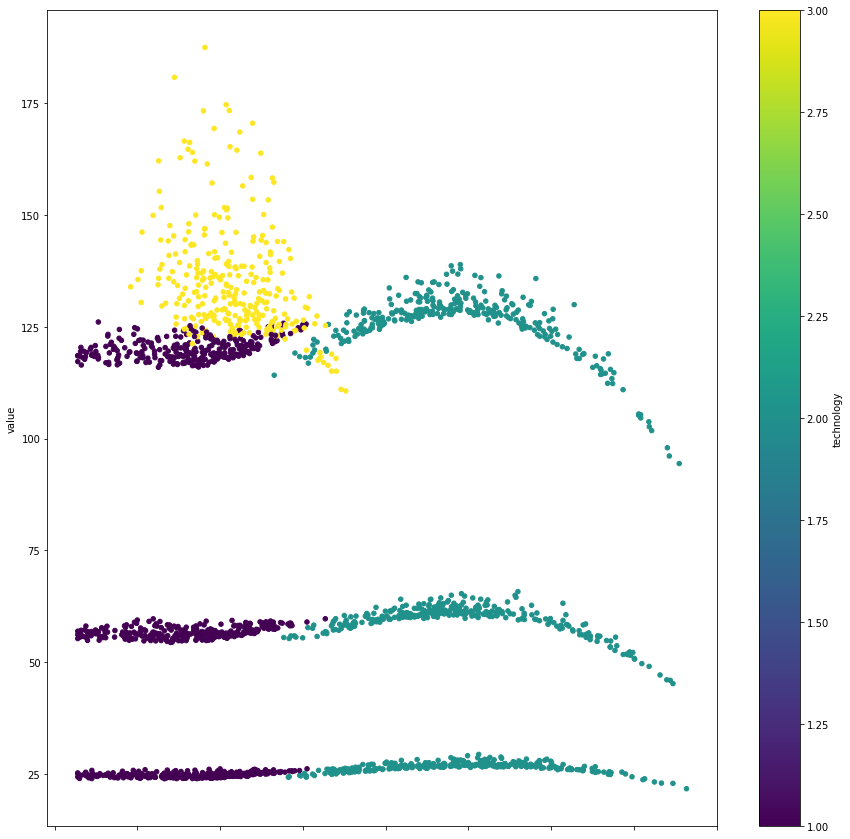

In [19]:
ax1 = df.plot.scatter(x='volume',
                      y='value',
                      c='technology',
                      cmap='viridis',
                      figsize=(15, 15),)

array([[<AxesSubplot:xlabel='scenario', ylabel='scenario'>,
        <AxesSubplot:xlabel='platform', ylabel='scenario'>,
        <AxesSubplot:xlabel='technology', ylabel='scenario'>,
        <AxesSubplot:xlabel='volume', ylabel='scenario'>,
        <AxesSubplot:xlabel='value', ylabel='scenario'>,
        <AxesSubplot:xlabel='t_x1', ylabel='scenario'>,
        <AxesSubplot:xlabel='t_x2', ylabel='scenario'>,
        <AxesSubplot:xlabel='t_x3', ylabel='scenario'>,
        <AxesSubplot:xlabel='x', ylabel='scenario'>,
        <AxesSubplot:xlabel='y', ylabel='scenario'>,
        <AxesSubplot:xlabel='z', ylabel='scenario'>],
       [<AxesSubplot:xlabel='scenario', ylabel='platform'>,
        <AxesSubplot:xlabel='platform', ylabel='platform'>,
        <AxesSubplot:xlabel='technology', ylabel='platform'>,
        <AxesSubplot:xlabel='volume', ylabel='platform'>,
        <AxesSubplot:xlabel='value', ylabel='platform'>,
        <AxesSubplot:xlabel='t_x1', ylabel='platform'>,
        <AxesSubplot:x

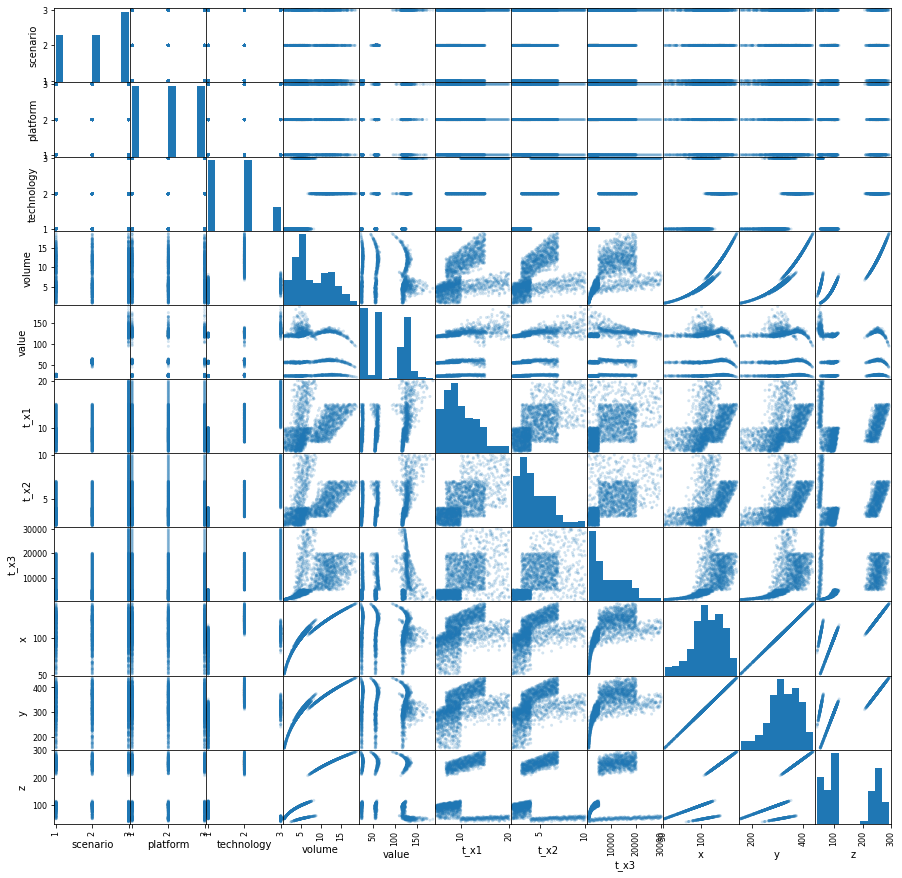

In [20]:
pd.plotting.scatter_matrix(df.filter(items=['scenario', 'platform', 'technology', 'volume', 'value', 't_x1', 't_x2', 't_x3', 'x', 'y', 'z']),
alpha=0.2,
figsize=(15, 15),)

In [21]:
print(designs[0][0][0].t_x1)
print(designs[1][0][0].t_x1)
print(designs[2][0][0].t_x1)

7.020202020202021
5.05050505050505
7.979797979797979


In [22]:
for design in designs[0][0]:
    print(design.value)

-24.823094494706194
-25.657440822195554
-25.54202137867513
-24.83997649973589
-24.3713328874639
-24.548631882754773
-24.34859427219148
-24.16062339320935
-25.6660217682671
-24.33785321254152
-24.370806468003355
-25.538889543475175
-24.39619989722312
-25.30735059270057
-24.58880684039509
-24.303319136134817
-26.13138591552488
-24.469251958840047
-24.398265961758387
-24.947080576468228
-24.82728475661149
-24.416503642265276
-25.362920983818086
-24.206237326896595
-24.176158595151687
-24.539178454214575
-26.03210213235411
-25.59876614899661
-24.704769664314696
-24.75454562962924
-25.016955775146027
-24.51549939659033
-25.022974611652522
-24.981540445732332
-26.0307658400823
-24.75335239510513
-24.000311102301474
-24.83159387755727
-24.393276820748493
-24.219507572420536
-25.63487176160826
-24.456391554212182
-24.170265938574754
-24.276935881594305
-24.499224923326857
-24.604444129350846
-24.585829835585724
-24.004113659110004
-24.494572949930717
-24.839175571620277
-25.5265300339338
-24.6

In [23]:
import seaborn as sns
sns.set_theme(style="whitegrid")

C:\Users\inigo\AppData\Roaming\Python\Python39\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\inigo\AppData\Roaming\Python\Python39\site-packages\seaborn\categorical.py:1296: UserWarning: 21.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\inigo\AppData\Roaming\Python\Python39\site-packages\seaborn\categorical.py:1296: UserWarning: 20.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\inigo\AppData\Roaming\Python\Python39\site-packages\seaborn\categorical.py:1296: UserWarning: 21.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


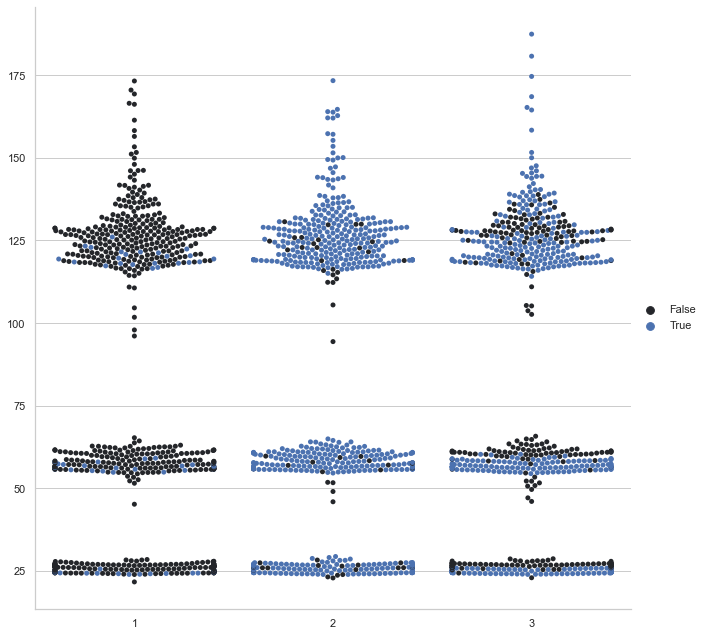

In [24]:
s1 = df[df['scenario'] == 1]
s2 = df[df['scenario'] == 2].reset_index()
s3 = df[df['scenario'] == 3].reset_index()
s23 = df[(df['scenario'] == 2) | (df['scenario'] == 3)].reset_index()

g = sns.FacetGrid(df, height=9, aspect=1)
g.map(sns.swarmplot, x="platform",
                    y="value",
                    hue="platform_compatible",
                    data=df, 
                    dodge=False)

g.add_legend()

In [25]:
s2

,index,scenario,platform,technology,platform_compatible,volume,value,t_x1,t_x2,t_x3,x,y,z
0,600,2,1,1,False,4.918035,55.796860,5.050505,3.656566,4070.707071,99.450555,298.351664,99.450555
1,601,2,1,1,False,5.899705,56.524143,6.666667,3.393939,4878.787879,105.670418,317.011253,105.670418
2,602,2,1,1,False,5.524417,56.565535,7.474747,3.030303,4151.515152,103.380545,310.141634,103.380545
3,603,2,1,1,False,4.556528,56.304016,5.454545,3.838384,3222.222222,96.951532,290.854595,96.951532
4,604,2,1,1,False,3.703743,56.017742,9.545455,2.000000,2454.545455,90.480911,271.442732,90.480911
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1195,2,3,2,False,15.267429,57.407754,14.030303,4.979798,18030.303030,136.522706,409.568118,273.045412
596,1196,2,3,2,False,12.139845,60.930410,10.151515,4.898990,17727.272727,126.479642,379.438927,252.959285
597,1197,2,3,2,False,12.832580,62.076320,12.818182,4.737374,9696.969697,128.841046,386.523138,257.682092
598,1198,2,3,2,False,9.991946,61.392585,9.424242,4.777778,7575.757576,118.531273,355.593818,237.062545


In [26]:
vwfo_i_k = 1/(len(designs[0][0])-1)
epsilon = 0

lista = []

for i in range(len(designs[0][1])):
    for j, items in enumerate(designs[0][0]):
        epsilon += np.sign(designs[0][0][j].value - designs[0][0][i].value)
    lista.append(epsilon * vwfo_i_k)

In [27]:
puntos1 = []
for i, design_i in s1.iterrows():
    N=0
    sigma=0
    if design_i['platform_compatible']:
        for j, design_j in s2.iterrows():
            if design_j['platform_compatible']:
                #print(design_i['value'], design_j['value'])
                sign = np.sign(design_j['value'] - s2.loc[i]['value'])
                #print(sign)
                sigma = sigma + sign
                N = N + 1
        design_i['vwfo'] = (1/(N-1)) * sigma
        puntos1.append(design_i['vwfo'])

In [28]:
puntos2 = []
for i, design_i in s2.iterrows():
    N=0
    sigma=0
    if design_i['platform_compatible']:
        for j, design_j in s3.iterrows():
            if design_j['platform_compatible']:
                #print(design_i['value'], design_j['value'])
                sign = np.sign(design_j['value'] - s3.loc[i]['value'])
                #print(sign)
                sigma = sigma + sign
                N = N + 1
        design_i['vwfo'] = (1/(N-1)) * sigma
        puntos2.append(design_i['vwfo'])

In [29]:
puntos3 = []
for i, design_i in s1.iterrows():
    N=0
    sigma=0
    if design_i['platform_compatible']:
        for j, design_j in s3.iterrows():
            if design_j['platform_compatible']:
                #print(design_i['value'], design_j['value'])
                sign = np.sign(design_j['value'] - s3.loc[i]['value'])
                #print(sign)
                sigma = sigma + sign
                N = N + 1
        design_i['vwfo'] = (1/(N-1)) * sigma
        puntos3.append(design_i['vwfo'])

In [30]:
print(np.average(puntos1))
print(np.average(puntos2))

0.045900230477753025
-0.043985050510034165


<AxesSubplot:>

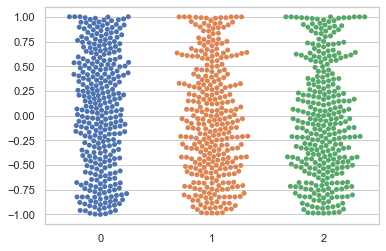

In [31]:
sns.swarmplot(data=[puntos1,puntos2,puntos3])

<AxesSubplot:>

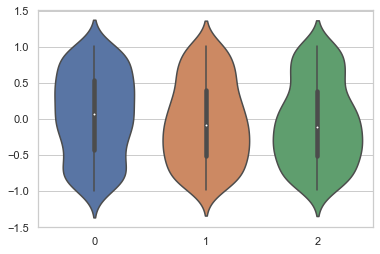

In [32]:
sns.violinplot(data=[puntos1,puntos2,puntos3])

In [33]:
puntos4 = [[],[],[]]
for i, design_i in s1.iterrows():
    N=0
    sigma=0
    if design_i['platform_compatible']:
        for j, design_j in s23.iterrows():
            if design_j['platform_compatible']:
                #print(design_i['value'], design_j['value'])
                sign = np.sign(design_j['value'] - s23.loc[i]['value'])
                #print(sign)
                sigma = sigma + sign
                N = N + 1
        design_i['vwfo'] = (1/(N-1)) * sigma
        puntos4[design_i['platform']-1].append(design_i['vwfo'])

<AxesSubplot:>

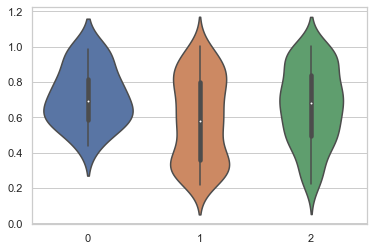

In [34]:
sns.violinplot(data=puntos4)

<AxesSubplot:>

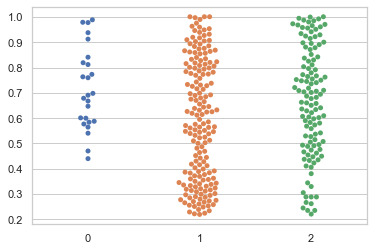

In [35]:
sns.swarmplot(data=puntos4)

<AxesSubplot:>

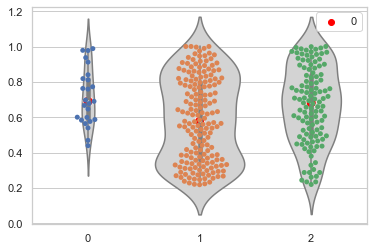

In [36]:
#fig, ax = plt.subplots()

sns.violinplot(data=puntos4, 
                    dodge=False,
                    color='lightgrey',
                    scale='count',
                    height=6, aspect=2)

df_medians = pd.DataFrame([[np.median(puntos4[0])],[np.median(puntos4[1])],[np.median(puntos4[2])]])

sns.swarmplot(data=puntos4, 
                    dodge=False)
                    
sns.scatterplot(data=df_medians,
palette=['red'],s=100)


C:\Users\inigo\AppData\Roaming\Python\Python39\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\inigo\AppData\Roaming\Python\Python39\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


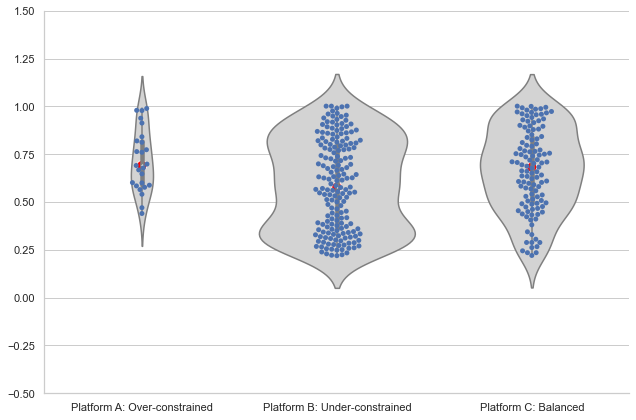

In [37]:
g = sns.FacetGrid(df, height=6, aspect=1.5, ylim=(-0.5,1.5))

g.map(sns.violinplot,
                    data=puntos4, 
                    dodge=False,
                    color='lightgrey',
                    scale='count')


g.map(sns.scatterplot,data=df_medians,
palette=['red'],s=100)

g.map(sns.swarmplot,data=puntos4, 
                    dodge=False)

#g.set_xlabels("Platforms")
g.set_xticklabels(["Platform A: Over-constrained", "Platform B: Under-constrained", "Platform C: Balanced"])

#g.add_legend()

In [38]:
print(np.median(puntos4[0]))
print(np.median(puntos4[1]))
print(np.median(puntos4[2]))

0.6909090909090909
0.5769696969696969
0.6824242424242424


In [39]:
g.savefig('platforms_flexibility.svg')